In [1]:
import deepxde as dde
import numpy as np
import torch

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
def func(x):
    return  - 1 / (np.pi**2) / 2 * np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

Compiling model...
'compile' took 0.182782 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.31e-01, 1.75e-02]    [2.65e-01, 1.75e-02]    []  
1000      [1.28e-03, 4.13e-05]    [9.86e-04, 4.13e-05]    []  
2000      [2.14e-04, 3.35e-05]    [1.66e-04, 3.35e-05]    []  
3000      [4.80e-05, 9.31e-06]    [3.45e-05, 9.31e-06]    []  
4000      [2.13e-05, 2.97e-06]    [1.46e-05, 2.97e-06]    []  
5000      [1.28e-05, 1.74e-06]    [8.62e-06, 1.74e-06]    []  
6000      [9.41e-06, 1.35e-06]    [6.23e-06, 1.35e-06]    []  
7000      [7.57e-06, 1.10e-06]    [4.98e-06, 1.10e-06]    []  
8000      [8.77e-06, 1.14e-06]    [7.21e-06, 1.14e-06]    []  
9000      [5.93e-06, 8.69e-07]    [3.91e-06, 8.69e-07]    []  
10000     [6.35e-06, 1.27e-06]    [4.60e-06, 1.27e-06]    []  

Best model at step 9000:
  train loss: 6.80e-06
  test loss: 4.78e-06
  test metric: []

'train' took 34.275089 s

Compiling model...
'compile' took 0.000481 s

Training m

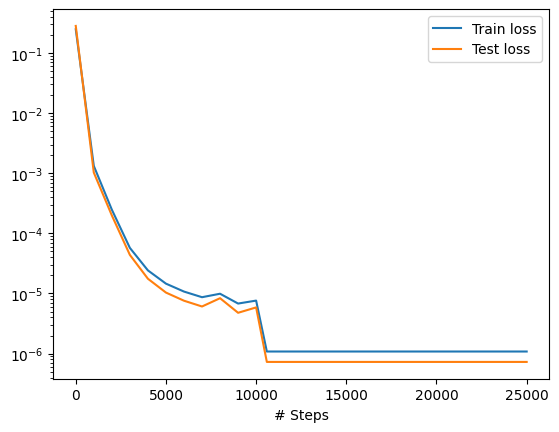

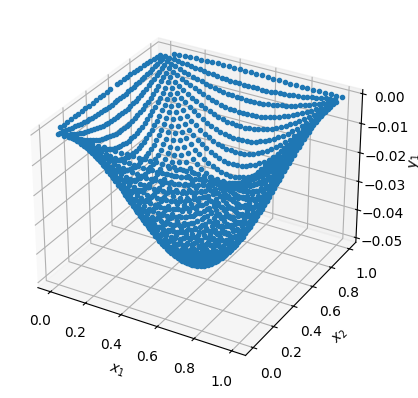

In [5]:
def pde(x, f):
    # Most backends
    df_xx = dde.grad.hessian(f, x, i=0, j=0)
    df_yy = dde.grad.hessian(f, x, i=1, j=1)
    return df_xx + df_yy - torch.sin(np.pi * x[:,0:1]) * torch.sin(np.pi * x[:,1:2]) 


def boundary(_, on_boundary):
    return on_boundary

geom = dde.geometry.Rectangle([0, 0], [1, 1])

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

data = dde.data.PDE(geom, pde, bc, solution=func,  num_domain=1200, num_boundary=120, num_test=1500)
net = dde.nn.FNN([2] + [10] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001)
model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

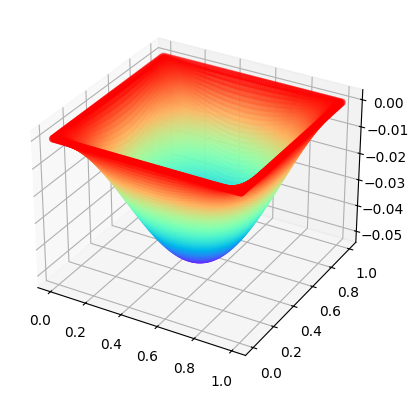

In [14]:
#plot a 2d function 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Generate or provide data
xs = np.linspace(0, 1, 100)
ys = np.linspace(0, 1, 100)
vals = func(np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)).reshape(100,100)

# 3d scatter plot
ax.scatter(np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)[:,0], np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2)[:,1], vals.reshape(-1), c=vals.reshape(-1), cmap='rainbow')

plt.show()

# Findings
My solution converges very quickly, the solution is plotted in blue dots and the exact solution is plotted in rainbow shape. The solution is very close to the exact solution.

The DeepXDE package is a very impressive package. It has a lot of useful APIs. For example, the easy definition of boundary by interface `gemoetry.Rectangle()`, `gemoetry.Polygon()`, and etc. The bad side is that it hides too much implementation. I feel like an API caller for this task.